## Note that the LLM used must support tool-calling

In [45]:
import asyncio
import json
from typing import List, Literal
from typing_extensions import Annotated
from concurrent.futures import ThreadPoolExecutor
from pprint import pprint

from langchain_core.rate_limiters import InMemoryRateLimiter
from langchain_core.messages import ToolMessage, AIMessage, HumanMessage, SystemMessage
from langchain.chat_models import init_chat_model
from langchain_core.tools import tool
from langchain_core.tools.base import InjectedToolCallId
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.runnables import RunnableConfig
from langchain_together import ChatTogether
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt.chat_agent_executor import AgentState
from decouple import config
from serpapi import GoogleSearch
from dotenv import load_dotenv
from youtube_transcript_api import YouTubeTranscriptApi

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableConfig
from langgraph.types import Send, Command
from langgraph.graph import END, START, StateGraph, MessagesState

load_dotenv()

SERPAPI_API_KEY = config("SERPAPI_API_KEY")
GROQ_API_KEY = config("GROQ_API_KEY")
TOGETHER_API_KEY = config("TOGETHER_API_KEY")

MODEL_NAME = "llama-3.3-70b-versatile" #"qwen-qwq-32b"
MAX_TOKENS = 2000  # Adjust based on API limit

# Define rate limiter (6,000 TPM → ~100 requests per minute max)
rate_limiter = InMemoryRateLimiter(
    requests_per_second=1.6,  # Ensures we stay within ~100 requests per minute
    check_every_n_seconds=0.1,
    max_bucket_size=10  # Allows for small bursts
)

# Note that the LLM used must support tool-calling

llm = init_chat_model( 
    model=MODEL_NAME, 
    model_provider="groq",
    temperature=0.4,
    api_key=GROQ_API_KEY,
    rate_limiter=rate_limiter
)

# The function/tool-calling LLMs available on Together.ai that actually work
# "Qwen/Qwen2.5-7B-Instruct-Turbo"
# "meta-llama/Meta-Llama-3.1-405B-Instruct-Turbo"

# These didn't work well:
# "mistralai/Mixtral-8x7B-Instruct-v0.1"
# "Qwen/Qwen2.5-72B-Instruct-Turbo"

llm = ChatTogether(
    model="meta-llama/Meta-Llama-3.1-405B-Instruct-Turbo",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)




In [53]:
# Create tools




@tool
async def search_youtube_video(title: str):
    """
    Search for a YouTube video based on a given title.

    Use this tool when you need to find a relevant YouTube video before retrieving its transcript.
    This tool returns the title, video link, and video ID, which can then be used for fetching the transcript.

    Input:
    - title: The search query for the YouTube video.

    Output:
    - A dictionary with:
      - 'title': The video title.
      - 'link': The direct URL to the video.
      - 'video_id': The unique YouTube video ID for transcript retrieval.
    """
    params = {
        "engine": "youtube",
        "search_query": title,
        "api_key": SERPAPI_API_KEY
    }
    search = GoogleSearch(params)
    
    # Run search in an async-compatible way
    results = await run_in_executor(search.get_dict)

    if "video_results" in results:
        video = results["video_results"][0]  # Get the first result
        return {
            "title": video["title"],
            "link": video["link"],
            "video_id": video["link"].split("v=")[-1]
        }
    return None


@tool
async def get_youtube_transcript(
    video_id: str,
    tool_call_id: Annotated[str, InjectedToolCallId], 
    config: RunnableConfig, 
):
    """
    Asynchronously fetch the transcript for a YouTube video.
    
    Use this tool when you have a video_id and need to retrieve the full transcript.
    The returned transcript may be very long and should be processed further.
    
    Input:
    - video_id: The unique identifier for the YouTube video.
    
    Output:
    - A string containing the full transcript.
    """
    try:
        raw_transcript = await run_in_executor(lambda: YouTubeTranscriptApi.get_transcript(video_id))
        transcript = " ".join([t["text"] for t in raw_transcript])
        return Command(
            update={
                "transcript": transcript,
                "messages": [
                    ToolMessage(
                        "Successfully added transcript to State", tool_call_id=tool_call_id
                    )
                ]
            },
        )
    except Exception as e:
        return f"Transcript not available: {e}"


tools = [search_youtube_video, get_youtube_transcript]
tool_node = ToolNode(tools)

llm_with_tools = llm.bind_tools(tools)

# Async-compatible executor for blocking operations
executor = ThreadPoolExecutor()

def run_in_executor(func, *args):
    """Helper function to run blocking tasks asynchronously."""
    loop = asyncio.get_running_loop()
    return loop.run_in_executor(executor, func, *args)


summarize_prompt = ChatPromptTemplate(
    [
        (
            "human",
            """You are an AI assistant summarizing a YouTube video for someone who cannot watch it. 
            
            **Objective**: Provide a well-structured, engaging, and detailed summary based on the given transcript chunk.
            
            - Capture the **key points, themes, and emotions**.
            - If it's a **story-driven** video (e.g., movies, vlogs), highlight **plot twists, character actions, and motivations**.
            - If it's **educational or informational**, focus on the **main insights, lessons, and takeaways**.
            - Keep it **concise yet descriptive**, making the user feel like they watched the video.
            - Don't mention "transcript" in the summary.
            
            Here is the first transcript segment:
            ----------------
            {context}
            ----------------
            
            Write a concise but detailed summary based on this content.
            """,
        )
    ]
)

initial_summary_chain = summarize_prompt | llm_with_tools | StrOutputParser()


refine_template = """
You are refining a summary of a YouTube video to make it **engaging, structured, and easy to understand**.

**Objective**: Merge the new context into the existing summary to create a refined version that truly reflects the video’s content.

### **Guidelines:**
- Maintain coherence and flow between the **existing summary** and **new context**.
- If the new content **introduces key moments**, ensure they are **properly included**.
- If it's a **story-driven video**, enhance descriptions of **plot developments, character actions, emotional moments, plot setting, location, time**.
- If it’s **informational**, refine the summary to **better capture main ideas and lessons**.
- Keep the summary **concise but engaging**, as if the user has watched the video.
- Don't mention "transcript" in the summary. Use a narrative tone as if you were Chimamanda Adichie or Morgan Freeman.

---

### **Existing summary up to this point:**
{existing_answer}

### **New transcript segment:**
{context}

---

Now, refine the original summary, ensuring the **final version is coherent, engaging, and informative**.
"""

refine_prompt = ChatPromptTemplate([("human", refine_template)])

refine_summary_chain = refine_prompt | llm_with_tools | StrOutputParser()





# We will define the state of the graph to hold the document
# contents and summary. We also include an index to keep track
# of our position in the sequence of documents.
# Define our state type (including the user's query, transcript chunks, summary, and index)
class State(AgentState):
    transcript: str       # The full transcript from get_youtube_transcript
    contents: List[str]   # Transcript chunks (to be populated by chunk_transcript)
    index: int            # Current index for summarization
    summary: str          # Accumulated summary


# We define functions for each node, including a node that generates
# the initial summary:
def chunk_transcript(
    state: State, 
    config: RunnableConfig, 
    chunk_size: int = 4000
):
    """
    Node for splitting long transcripts into smaller chunks for processing.

    This node takes a transcript from the state and divides it into manageable chunks 
    to facilitate downstream processing.

    Parameters:
    - state (State): The current pipeline state containing the transcript.
    - config (RunnableConfig): Configuration settings for execution.
    - chunk_size (int, optional): Maximum number of characters per chunk. Defaults to 2000.

    Returns:
    - dict: A dictionary with a "content" key containing a list of transcript chunks.
    """
    transcript = state.get("transcript")
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size, chunk_overlap=400
    )
    
    transcript_chunks = splitter.split_text(transcript)
    return {"contents": transcript_chunks}
  


async def generate_initial_summary(state: State, config: RunnableConfig):
    summary = await initial_summary_chain.ainvoke(
        {"context": state["contents"][0]},
        config,
    )
    return {"summary": summary, "index": 1}


# And a node that refines the summary based on the next document
async def refine_summary(state: State, config: RunnableConfig):
    content = state["contents"][state["index"]]
    summary = await refine_summary_chain.ainvoke(
        {"existing_answer": state["summary"], "context": content},
        config,
    )

    return {"summary": summary, "index": state["index"] + 1}


# Here we implement logic to either exit the application or refine
# the summary.
def should_refine(state: State) -> Literal["refine_summary", END]:
    if state["index"] >= len(state["contents"]):
        return END
    else:
        return "refine_summary"

# --- Tool-Calling Phase Nodes ---
# This node calls the LLM, which might output a tool call (e.g. call get_youtube_transcript)
def call_model(state: State):
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)  # LLM may include tool_calls if a tool is needed
    return {"messages": [response]}

def should_continue(state: State) -> Literal["tools", "chunk_transcript", END]:
    """
    Determines the next step in the processing pipeline.

    Returns:
    - "tools": If the last message includes a tool call
    - "chunk_transcript": If the transcript exists but hasn't been chunked yet.
    - END: If no further processing is needed.
    """
    messages = state["messages"]
    last_message = messages[-1]
    # If there's an outstanding tool call, let the tools node process it.
    if last_message.tool_calls:
        return "tools"
    # If transcript exists but we haven't chunked it yet, prompt the LLM to call chunk_transcript.
    elif state.get("transcript") and not state.get("contents"):
        return "chunk_transcript"
    return END



In [54]:
# --- Graph Arrangement ---

graph = StateGraph(State)

# Tool-calling part: to sequentially invoke the YouTube tools if needed.
# Add nodes.
graph.add_node("agent", call_model)
graph.add_node("tools", tool_node)
graph.add_node("chunk_transcript", chunk_transcript)
graph.add_node("generate_initial_summary", generate_initial_summary)
graph.add_node("refine_summary", refine_summary)

# Arrange edges for the tool-calling phase.
graph.add_edge(START, "agent")
graph.add_conditional_edges("agent", should_continue, {
    "tools": "tools",                     # If tool calls exist.
    "chunk_transcript": "chunk_transcript",  # If the transcript is available.
    END: END                              # Otherwise, end the workflow.
})
graph.add_edge("tools", "agent")  # After executing tools, return to the agent.

# After creating chunks of the transcript, start iterative summarization 
# beginning with the first chunk
graph.add_edge("chunk_transcript", "generate_initial_summary")
# Arrange edges for the summarization phase. 
graph.add_conditional_edges("generate_initial_summary", should_refine, {
    "refine_summary": "refine_summary",
    END: END
})
graph.add_conditional_edges("refine_summary", should_refine, {
    "refine_summary": "refine_summary",
    END: END
})

# Compile the graph.
app = graph.compile()

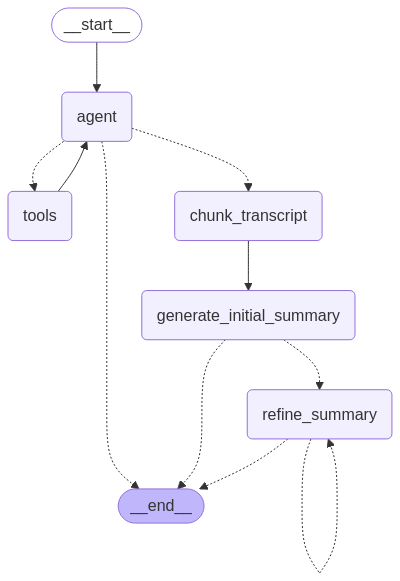

In [58]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [59]:
from IPython.display import Image, display
import os

# Ensure the assets directory exists
os.makedirs("assets", exist_ok=True)

# Save the diagram to a file in the assets folder
graph_png_path = "assets/graph_diagram.png"
try:
    graph_png = app.get_graph().draw_mermaid_png()
    with open(graph_png_path, "wb") as f:
        f.write(graph_png)
    print(f"Graph saved to {graph_png_path}")
except Exception:
    # This requires some extra dependencies and is optional
    print("Error generating or saving the graph.")

Graph saved to assets/graph_diagram.png


In [56]:
query = "Love in Every Word by Omoni Oboli"
query = "Love in Every Word (Odogwu Paranra) by Omoni Oboli"
query = "Odogwu Paranra"
query = "I had postpartum depression Bam Bam"
query = "Love in Every Word (Odogwu Paranra) by Omoni Oboli shorts"
query = "GOLD DIGGERS - UZOR ARUKWE"

# Run the workflow
final_state = None
async for chunk in app.astream(
    {"messages": [("user", query)]}, {"recursion_limit": 50}, stream_mode="values"
):
    final_state = chunk


In [57]:
summary = final_state.get("summary", "") if final_state else ""
video_link = None

if final_state:
    for message in final_state.get("messages", []):
        if getattr(message, "name", None) == "search_youtube_video":
            try:
                # Convert string content to a dictionary
                payload = json.loads(message.content)  # Parse the JSON string
                video_link = payload.get("link")  # Extract video link
                title = payload.get("title")
                break  # Stop after finding the first valid link
            except json.JSONDecodeError:
                continue  # Skip if content is not valid JSON

    pprint({"title": title, "summary": summary, "video_link": video_link})

{'summary': 'The video presents a story-driven conversation between Victor and '
            "Nora, which begins with Victor asking for Nora's number. However, "
            "she declines, stating she doesn't know him. The dynamic shifts "
            "when Victor shows off his car, sparking Nora's interest, and she "
            'introduces herself. Victor accuses Nora of being a "gold digger," '
            "claiming she's only interested in him because of his wealth.\n"
            '\n'
            "As the conversation unfolds, it's revealed that Victor doesn't "
            'actually own the car but borrowed it from a car wash. Nora feels '
            'deceived, calling Victor a "bastard." Victor defends himself, '
            "stating he's a promising young man with a degree in accounting "
            'and financial analysis, and that content creation is just a side '
            'hustle.\n'
            '\n'
            'The conversation takes a turn when Victor offers to suppor